<a href="https://colab.research.google.com/github/Shruti-Raj-Vansh-Singh/Deep-Learning/blob/master/Art_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ART GENERATION USING NEURAL STYLE TRANSFER

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time 
import functools

### Defining some useful modules

In [3]:
def tensor_to_image(tensor):
  tensor *=255
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor)>3:
    assert tesnor.shape[0]==0
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Defining a path for the content and style image 

In [4]:
"""USE THIS CODE WHEN YOU WANT TO DOWNLOAD THE IMAGES FROM THE INTERNET
content_path = tf.keras.utils.get_file("Girls.jpg","*path*")
style_path = tf.keras.util.get_file("abstract.jpg", https://www.itl.cat/pngfile/big/38-384952_abstract-iphone-wallpaper-hd-free-hd-wallpaper-throughout.jpg')
"""
content_path = '/content/content.jpg'
style_path = '/content/style.jpg'

### Functions for visualization

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = PIL.Image.open(path_to_img)
  leng = max(img.size)
  scale = max_dim/leng
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)

  img = tf.keras.preprocessing.image.img_to_array(img)

  #we need to bradcast the image array such that it has a batch dimension
  img = np.expand_dims(img, axis=0)

  return img


In [6]:
def display_img(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

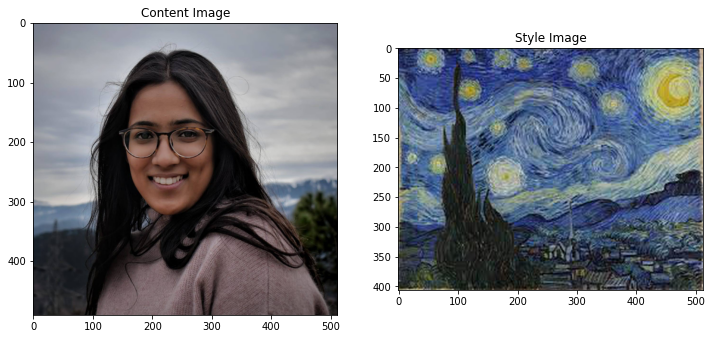

In [23]:
#let us view our content and style image
content_img = load_img(content_path)
style_img = load_img(style_path)

plt.subplot(1,2,1)
display_img(content_img,'Content Image')

plt.subplot(1,2,2)
display_img(style_img,'Style Image')

plt.show()

We will be using transfer learning to process our model. In this case we will be using VGG19 model as ur base model and hence we need to prepare our images according to the requirement of the VGG model.

In [28]:
def load_preprocess_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

To the suit the model we decoded our input image, but to view it we will need to decode it too. \
Input to deprocess must be an image of dimension [1, height, width, channel] or [height, width, channel] \
The value of mean to normalize each channel in vgg19 is 103.939, 116.779, 123.68 

In [9]:
def deprocess(img):
  x = img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x,0)
  assert len(x.shape) == 3, "Input dimensiion must ne 4 or 3"

  x[: ,:, 0] += 103.939
  x[:, :, 1] += 116.779
  x[: ,:, 2] += 123.68

  x = np.clip(x,0,255).astype('uint8')

  return x

Loading the pre-trained VGG19 model, first with the classfication head to check the working(can skip this)

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_img*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top =  True, weights = 'imagenet')
pred = vgg(x)
pred.shape

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [11]:
predict_5 = tf.keras.applications.vgg19.decode_predictions(pred.numpy())[0]
[(class_name, prob) for (number, class_name, prob ) in predict_5]

40960/35363 [==================================] - 0s 0us/step


[('prayer_rug', 0.99997115),
 ('shower_curtain', 2.8899422e-05),
 ('pillow', 6.2949335e-25),
 ('toilet_tissue', 0.0),
 ('Angora', 0.0)]

loading the vgg 19 pre trianed model without the classification head

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


We can see that we have 5 blocks in the vgg19 network. We will choose the last layer for our content and initial layers of each block for our style

In [13]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Building our model

In [26]:
def get_model():
  "Create a model to access intermediate layers"
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  style_output = [vgg.get_layer(name).output for name in style_layers]
  content_output = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_output+content_output
  return tf.keras.Model(vgg.input, model_outputs)

## Loss functions

### Content Loss
To find the content loss, we will pass both our content and base image to the network and get the intermediate layer output from our model. To find the content loss, we simply use the **euclidean distance** between the raw intermediate represenations of both the images. \

We perform backpropagation in the usual way such that we minimize this content loss. We thus change the initial image until it generates a similar response in a certain layer (defined in content_layer) as the original content image.

In [93]:
def content_loss(base_img, content_img):
  return tf.reduce_mean((base_img-content_img)**2)

### Style loss
To compute the style loss, we will take the base image and the content image and compare the **Gram Matrix** of the two outputs of the network.
We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix Gl, where Glij is the inner product between the vectorized feature map i and j in layer l. We can see that Glij generated over the feature map for a given image represents the correlation between feature maps i and j.  \

To generate a style for our base input image, we perform gradient descent from the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image.

In [94]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor,[-1,channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a,a, transpose_a=True)
  return gram/tf.cast(n,tf.float32)

In [95]:
def style_loss(base_img, style_img):
  height, width, channels = base_img.get_shape().as_list()
  gram_style = gram_matrix(base_img)

  return tf.reduce_mean((gram_style-style_img)**2)

## Running the model

In [96]:
def preprocess(model, content_path, style_path):
  content_img = load_preprocess_img(content_path)
  style_img = load_preprocess_img(style_path)

  #now we will fetch the features of the content and style image by passing it to the model
  content_output = model(content_img)
  style_output = model(style_img)

  #getting the desrired features according to the layers mentioned above
  style_features = [style_layer[0] for style_layer in style_output[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_output[num_style_layers:]]

  return style_features, content_features

## Computing the loss function

In [97]:
def compute_loss(model, loss_weights, base_img, gram_style, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(base_img)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  #finding loss on the style layer. We will gove equal weightage to each layer
  weight_per_style_layer = 1.0/float(num_style_layers)
  for target_style, style in zip(gram_style, style_output_features):
    style_score += weight_per_style_layer*style_loss(style[0], target_style)

  #finding loss on the content layer. We will give equal weights to each layer
  weight_per_content_layer = 1.0/float(num_content_layers)
  for target_content, content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer*content_loss(content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  #final loss
  loss = style_score+content_score

  return loss, style_score, content_score


In [104]:
def compute_gradient(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]    #loss wrt input image
  return tape.gradient(total_loss, cfg['base_img']), all_loss

## Optimization

In [113]:
import IPython.display

def art_generation(content_path, style_path, num_iterations=100, content_weight=1e3, style_weight=1e-2):
  #calling the model
  model = get_model()
  for layer in model.layers:
    layer.trainable = False

  style_features, content_features = preprocess(model, content_path, style_path)
  gram_style = [gram_matrix(style_feature) for style_feature in style_features]

  #initializing the base image
  base_img = load_preprocess_img(content_path)
  base_img = tf.Variable(base_img, dtype=np.float32)

  #ooptimizer 
  opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

  iter_count=1

  best_loss, best_img = float('inf'), None

  loss_weights = (content_weight, style_weight)

  cfg = {'model':model, 'loss_weights':loss_weights, 'base_img':base_img, 'gram_style':gram_style, 'content_features': content_features}

  #for diaplaying the output
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_time = time.time()

  norm_mean = np.array([130.989, 116.779, 123.68])      #normalization mean for vgg19
  min_val = -norm_mean
  max_val = 255-norm_mean

  imgs = []     #a list to store all the images generated
  for i in range(num_iterations):
    grads, all_loss = compute_gradient(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, base_img)])
    clipped = tf.clip_by_value(base_img, min_val, max_val)
    base_img.assign(clipped)
    end_time = time.time()

    if loss<best_loss:
      best_loss = loss
      best_img = deprocess(base_img.numpy())

    if i%display_interval==0:
      start_time = time.time()

      plot_img = base_img.numpy()
      plot_img = deprocess(base_img.numpy())
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(PIL.Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

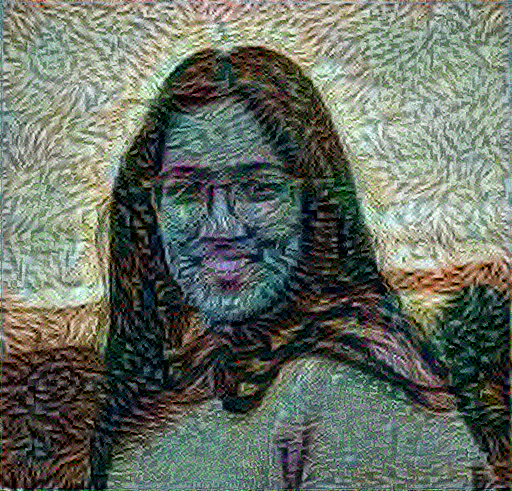

Iteration: 90
Total loss: 2.0052e+11, style loss: 2.0052e+11, content loss: 2.5770e+01, time: 0.0727s


NameError: ignored

In [114]:
best, best_loss = art_generation(content_path, style_path, num_iterations=100)

In [ ]:
PIL.Image.fromarray(best_img)

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [ ]:
show_results(best, content_path, style_path)